In [1]:
import numpy as np
import pandas as pd
from math import log2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install pymorphy3
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords
from catboost import CatBoostRanker

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 54.7 MB/s eta 0:00:00
/kaggle/input/21-vek-by-searched-products-ranking/products.csv
/kaggle/input/21-vek-by-searched-products-ranking/sample_submission.csv
/kaggle/input/21-vek-by-searched-products-ranking/train.csv
/kaggle/input/21-vek-by-searched-products-ranking/test.csv


# **1) Load data and first look**

In [2]:
df_sessions_train = pd.read_csv('/kaggle/input/21-vek-by-searched-products-ranking/train.csv')
df_sessions_test = pd.read_csv('/kaggle/input/21-vek-by-searched-products-ranking/test.csv')
df_products = pd.read_csv('/kaggle/input/21-vek-by-searched-products-ranking/products.csv')
submission = pd.read_csv('/kaggle/input/21-vek-by-searched-products-ranking/sample_submission.csv')

In [3]:
df_products.head()

,product_id,replaced_by,type,model,brand,country,category_name_1,category_name_2,category_name_3,category_name_4,date_of_create
0,9497304,0,Сменный блок для освежителя воздуха,Automatic I Love You (269мл),Glade,РОССИЯ,Товары для дома,Бытовая химия,Освежители воздуха,Освежитель воздуха,2025-01-29
1,9568803,0,Сироп,Маскарпоне (1л),Spoom,РОССИЯ,Товары для дома,Бакалея,Сиропы и топпинги,Сироп,2025-03-04
2,9568807,0,Топпинг,Банан (1л),Spoom,РОССИЯ,Товары для дома,Бакалея,Сиропы и топпинги,Сироп,2025-03-04
3,9568811,0,Сироп,Гранат (1л),Spoom,РОССИЯ,Товары для дома,Бакалея,Сиропы и топпинги,Сироп,2025-03-04
4,9799984,0,Спрей от насекомых,Gold Детский спрей от комаров / Ins125/SprotK...,Inseense,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2025-06-26


In [4]:
df_sessions_train.head()

,query,date,device,user_number,search_number,product_id,selected_category_id,product_position,response_products,response_time,browse_time,filters_applied,price_is_discounted,price_is_super,price,price_discount,available,relevance
0,bagi,2024-07-03,desktop,119760,1963,6221252,10709,2,9,76,2525,0,0,0,2940,0,2,0
1,bagi,2024-07-03,desktop,119760,1963,6221258,10718,3,3,75,2525,0,0,0,2036,0,2,2
2,bagi,2024-07-03,desktop,119760,1963,6221260,10718,1,3,75,2525,0,0,0,1955,0,2,1
3,bagi,2024-07-03,desktop,119760,1963,6221262,10718,2,3,75,2525,0,0,0,2442,0,2,0
4,bagi,2024-07-03,desktop,119760,1963,6221264,10709,9,9,76,2525,0,0,0,2165,0,2,0


In [5]:
print("Number of products:", len(df_products))
print("\nColumn information:")
print(df_products.info())
print("\nColumn gaps:")
print(df_products.isna().sum())

Number of products: 36673

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36673 entries, 0 to 36672
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product_id       36673 non-null  int64 
 1   replaced_by      36673 non-null  int64 
 2   type             36673 non-null  object
 3   model            36673 non-null  object
 4   brand            36673 non-null  object
 5   country          36673 non-null  object
 6   category_name_1  36673 non-null  object
 7   category_name_2  36673 non-null  object
 8   category_name_3  36673 non-null  object
 9   category_name_4  36673 non-null  object
 10  date_of_create   36673 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.1+ MB
None

Column gaps:
product_id         0
replaced_by        0
type               0
model              0
brand              0
country            0
category_name_1    0
category_name_2    0
category_name_3    0
c

# **2) EDA**

In [6]:
# Chart settings
sns.set_style("whitegrid")   
plt.rcParams['figure.figsize'] = (12,6)

# Creating a product age
df_products['date_of_create'] = pd.to_datetime(df_products['date_of_create'])
df_products['product_age_days'] = (pd.Timestamp('today') - df_products['date_of_create']).dt.days

# Counting how many times each product appears in sessions
popularity = df_sessions_train.groupby('product_id')['relevance'].mean().reset_index(name='avg_relevance')

# Connecting to the product dataframe
df = df_products.merge(popularity, on='product_id', how='left').fillna(-1)

# Let's look at the correlation
print(df[['product_age_days', 'avg_relevance']].corr())

                  product_age_days  avg_relevance
product_age_days          1.000000      -0.438239
avg_relevance            -0.438239       1.000000


#### The correlation between product age and the target variable is small (almost zero). Older products are purchased slightly more often, but the difference is insignificant.

count    36673.000000
mean      1877.442969
std       1862.792433
min         43.000000
25%        502.000000
50%       1267.000000
75%       2373.000000
max       5779.000000
Name: product_age_days, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


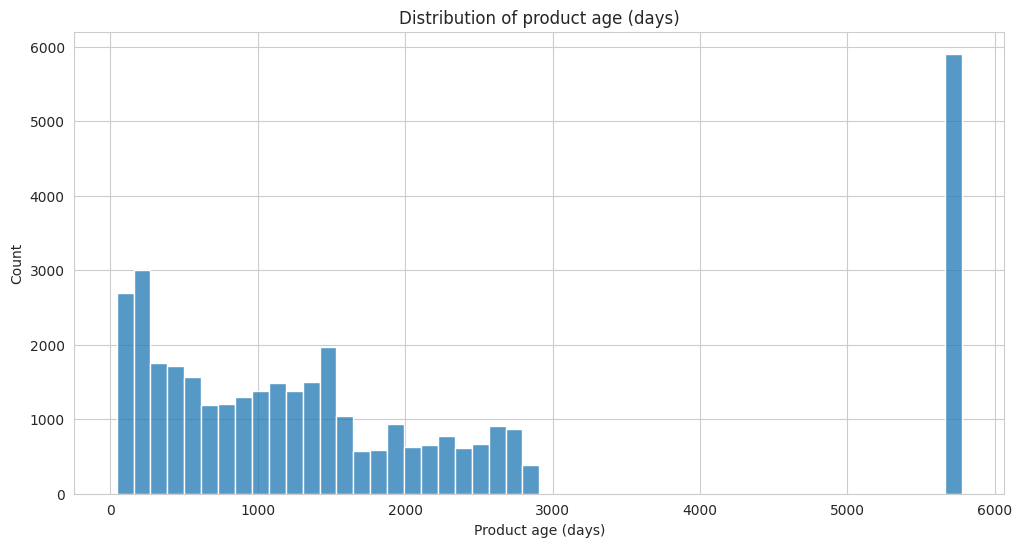

In [7]:
print(df_products['product_age_days'].describe())

sns.histplot(df_products['product_age_days'], bins=50)
plt.title('Distribution of product age (days)')
plt.xlabel('Product age (days)')
plt.show()

#### As you can see, most of the items were posted less than 3,000 days ago (about 8 years). However, there are also items that are 5,775 days old (or about 16 years old). Let's analyze the older items.

In [8]:
df_products[df_products['product_age_days'] > 5000].head(25)

,product_id,replaced_by,type,model,brand,country,category_name_1,category_name_2,category_name_3,category_name_4,date_of_create,product_age_days
85,480627,0,Набор для посудомоечных машин,Соль + Порошок с эффектом соды + Ополаскиватель,Сомат,РОССИЯ,Товары для дома,Бытовая химия,Средства для посудомоечных машин,Средство для посудомоечных машин,2010-01-01,5779
130,481129,0,Антимоль,Лаванда / ST1012,Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
131,481135,0,Антимоль,Лаванда / G0001,Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
132,481141,0,Аэрозоль от насекомых,От моли с ароматом лимона / 57418524,Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
133,481160,0,Антимоль,Апельсин / D9204M,Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
134,481163,0,Набор ловушек для насекомых,От тараканов / 57506054 (6шт),Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
135,481165,0,Гель от насекомых,57523049 (75мл),Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
136,481166,0,Ловушка для насекомых,От тараканов повышенной эффективности / s2003...,Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
137,481167,0,Антимоль,Мандарин / ST1011,Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779
138,481169,0,Антимоль,Жасмин / ST1013,Раптор,РОССИЯ,Товары для дома,Бытовая химия,Средства от насекомых,Средство от насекомых,2010-01-01,5779


#### This value is a placeholder, you can add a feature that will indicate this.

In [9]:
df_products['elden_product'] = (df_products['product_age_days'] > 5000).astype(int) # Creating a separate feature for objects created on 01-01-2010

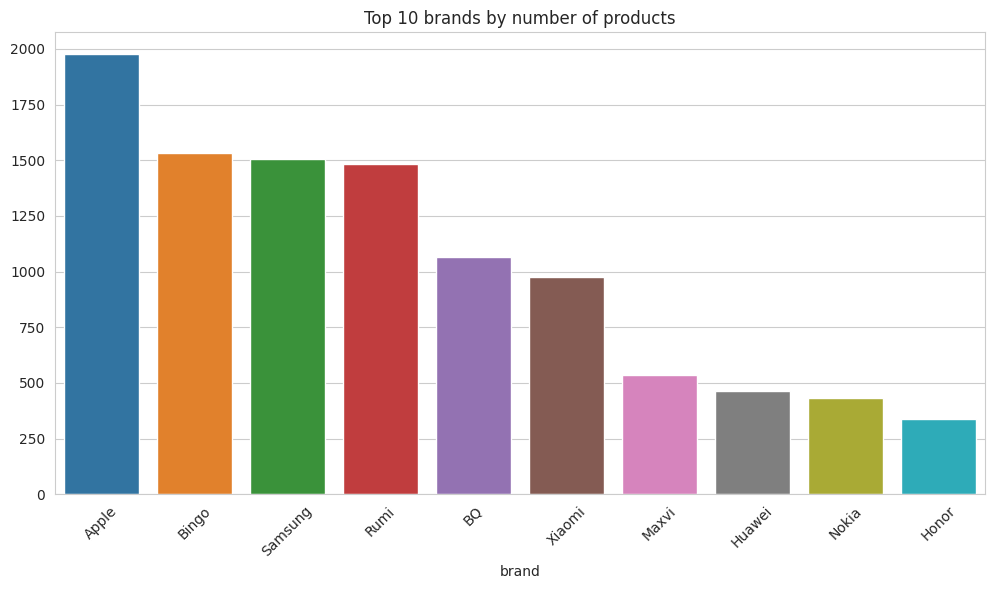

In [10]:
top_brands = df_products['brand'].value_counts().head(10)
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.xticks(rotation=45)
plt.title('Top 10 brands by number of products')
plt.show()

#### Phone manufacturers account for the majority of the market share. Moreover, Apple's product line significantly outstrips that of other brands, not only within its category but also overall. If one-hot encoding is planned for future use, it makes sense to group smaller brands into "Others".

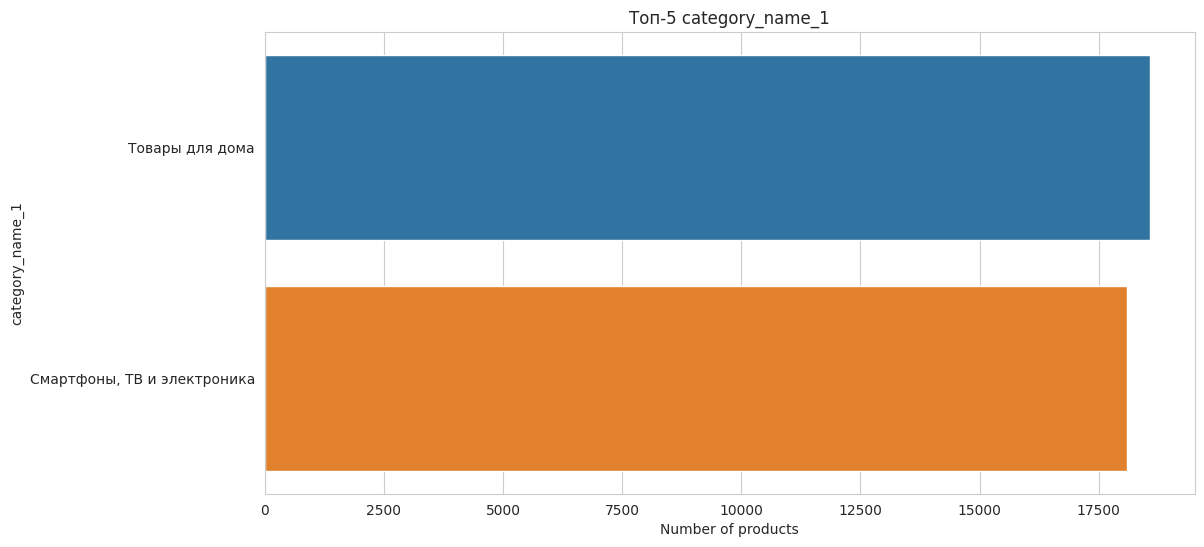

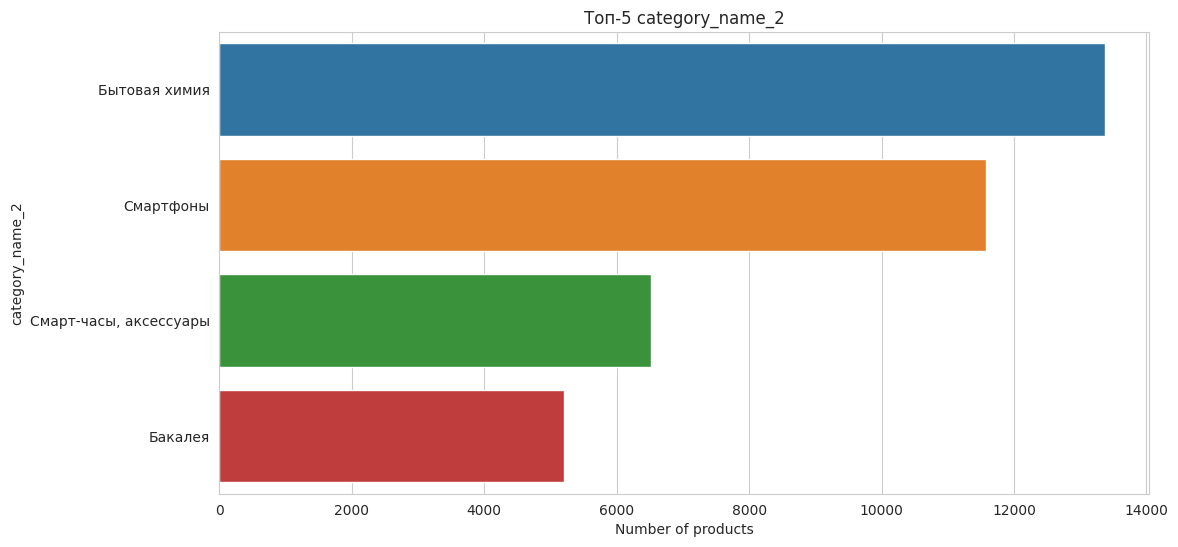

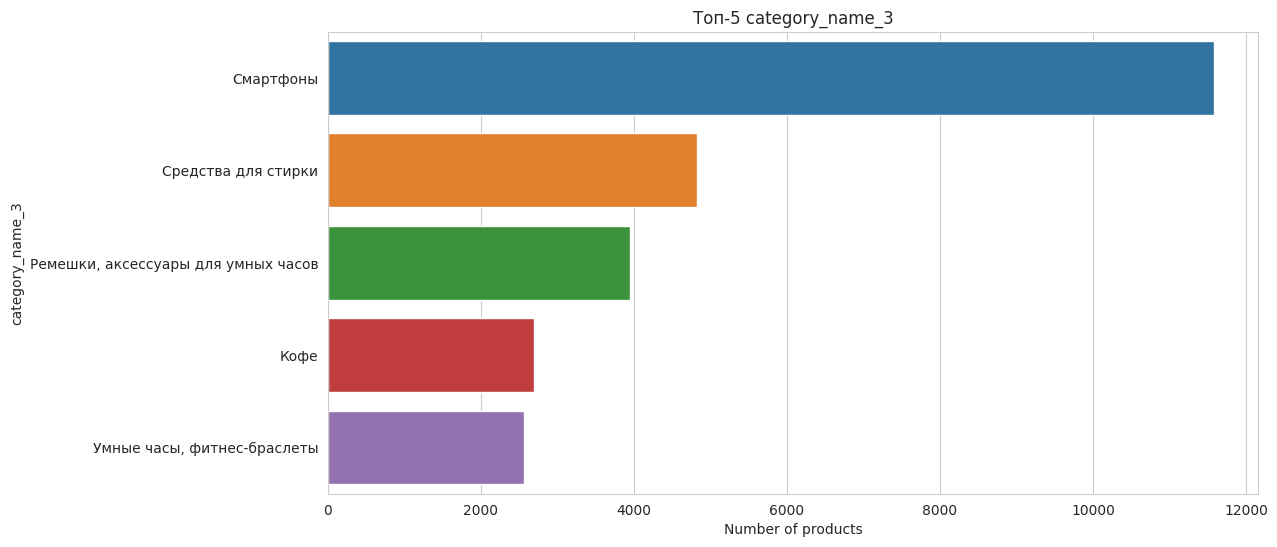

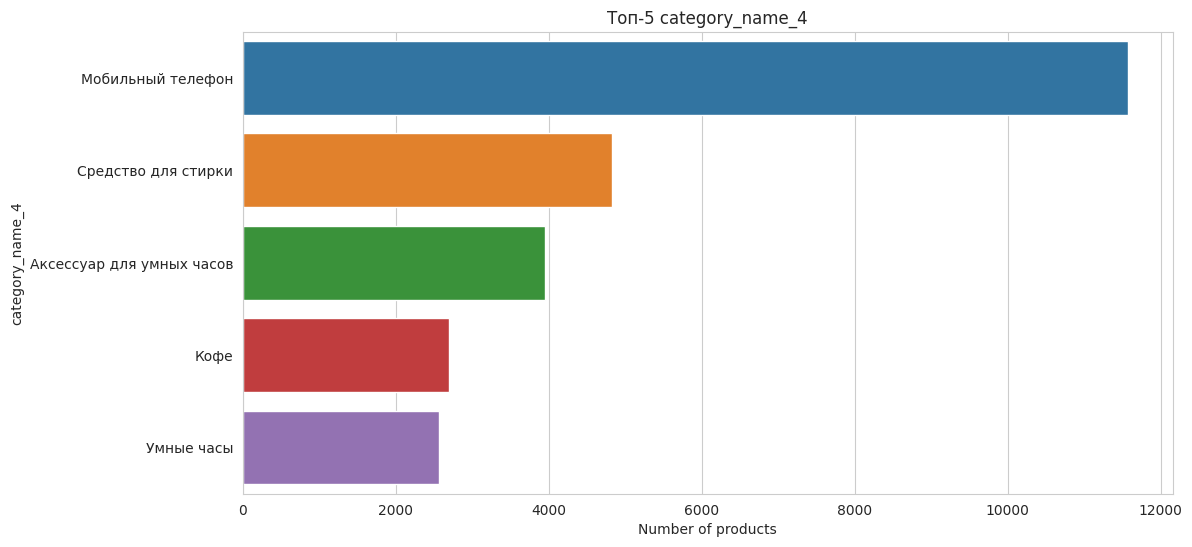

In [11]:
for col in ['category_name_1','category_name_2','category_name_3','category_name_4']:
    counts = df_products[col].value_counts().head(5)
    sns.barplot(y=counts.index, x=counts.values)
    plt.title(f'Топ-5 {col}')
    plt.xlabel('Number of products')
    plt.show()

#### The first distribution shows that both categories are virtually identical. Most likely, the feature itself doesn't correlate particularly well with the target variable. However, they can be analyzed and used to create new features. It's also clear that although electronics and home goods initially appear equally frequently, as you drill down into the categories, phones leap ahead, accounting for about half of all positions.

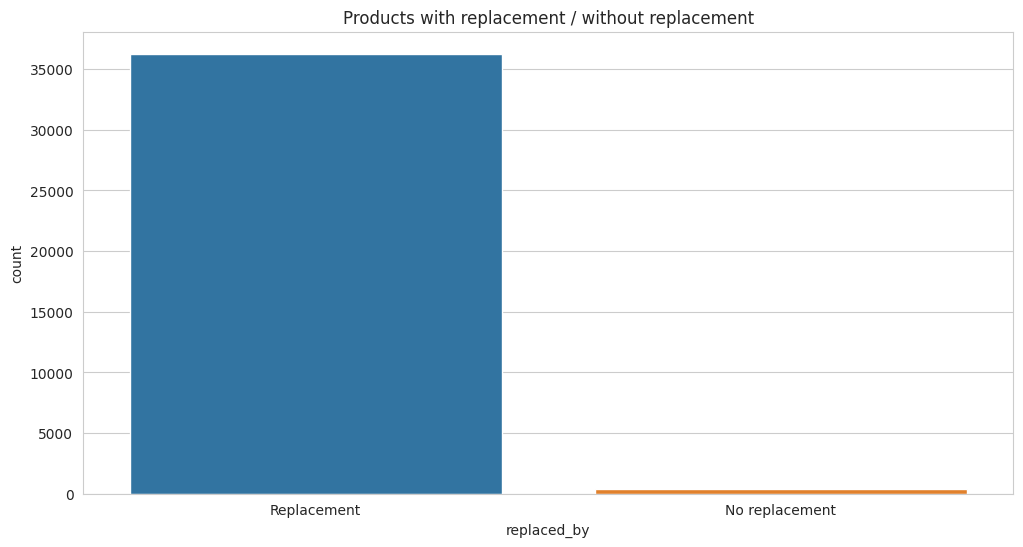

In [12]:
sns.countplot(x=(df_products['replaced_by'] != 0))
plt.xticks([0,1], ['Replacement', 'No replacement'])
plt.title('Products with replacement / without replacement')
plt.show()

#### Mostly, the products don't change, but remain in their original positions. Most likely, this indicator isn't particularly informative.

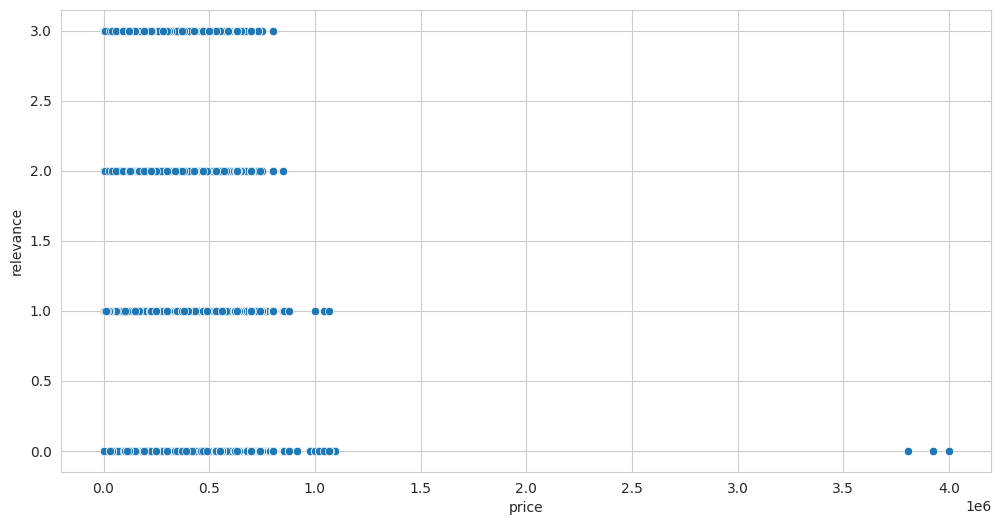

In [13]:
df_s_p = df_sessions_train.merge(df_products, on='product_id', how='left')
sns.scatterplot(data=df_s_p, x='price', y='relevance')
plt.show()

In [14]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None)
df_s_p[df_s_p['price']>3.5*10**6]

,query,date,device,user_number,search_number,product_id,selected_category_id,product_position,response_products,response_time,browse_time,filters_applied,price_is_discounted,price_is_super,price,price_discount,available,relevance,replaced_by,type,model,brand,country,category_name_1,category_name_2,category_name_3,category_name_4,date_of_create,product_age_days,elden_product
3297157,ariel,2025-03-12,app,94696,406196,7763297,399,61,100,35,2703,0,0,0,3808208,0,0,0,0,Пятновыводитель,Diamond Bright для тканей порошкообразный для цветного (500г),Ariel,РОССИЯ,Товары для дома,Бытовая химия,Средства для стирки,Средство для стирки,2022-09-20,1134,0
3336983,для стиральной машины,2025-03-12,app,164244,407249,9462594,399,74,52,157,933,1,0,0,3925280,0,0,0,0,Стиральный порошок,Апельсин и лимон Автомат (350г),Биолан,РОССИЯ,Товары для дома,Бытовая химия,Средства для стирки,Средство для стирки,2025-01-13,288,0
3341000,bimax,2025-03-12,mobile,94507,36335,9462587,399,13,15,303,414,0,0,0,4000797,0,0,0,0,Стиральный порошок,100 пятен Automat (1.5кг),Bimax,РОССИЯ,Товары для дома,Бытовая химия,Средства для стирки,Средство для стирки,2025-01-13,288,0


In [15]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

#### As you can see, these three values ​​are anomalies (most likely data entry errors), since laundry detergents can't cost that much. If you filter out these three entries, you'll see that there's no critical relationship between price and the target variable.

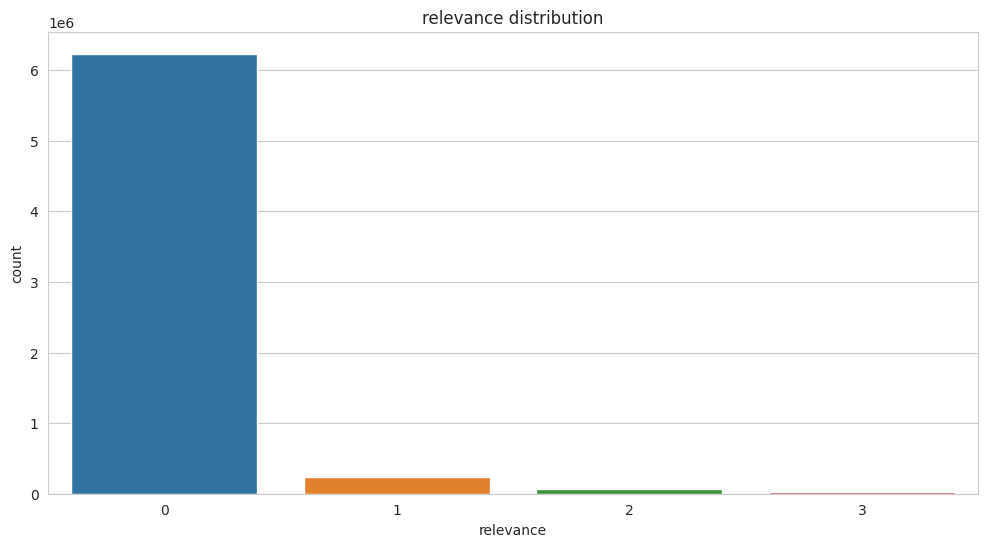

In [16]:
sns.countplot(x='relevance', data=df_sessions_train)
plt.title('relevance distribution')
plt.show()

#### It is also logical that at each stage from viewing to purchasing, the amount of relevance will decrease significantly.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


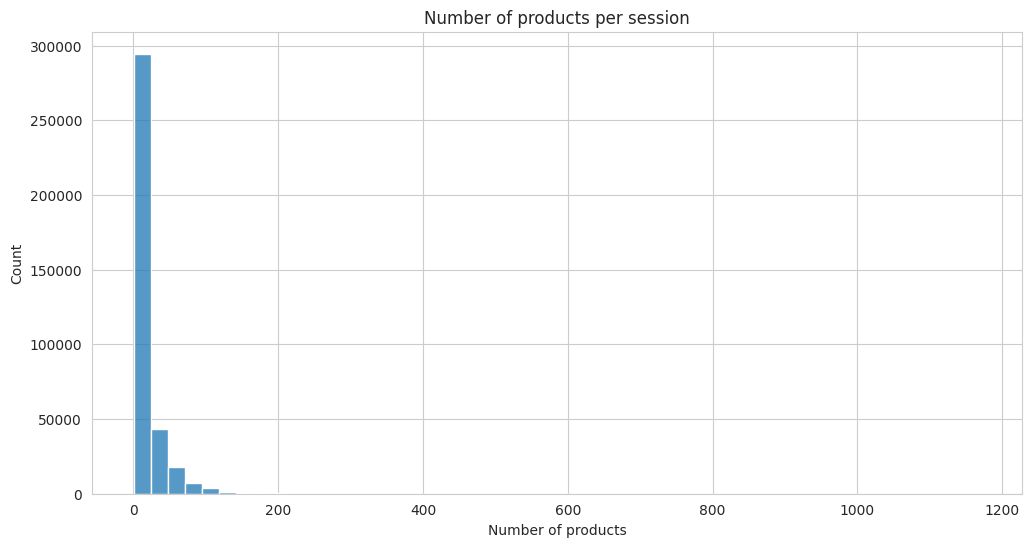

In [17]:
session_counts = df_sessions_train.groupby('search_number')['product_id'].count()
sns.histplot(session_counts, bins=50)
plt.title('Number of products per session')
plt.xlabel('Number of products')
plt.show()

In [18]:
session_counts[session_counts>1000]

search_number
347404    1169
Name: product_id, dtype: int64

#### What is also logical is that most often the sessions will be short, so most often there will be few products viewed

In [19]:
# Let's further analyze the suspiciously long session
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
long_session = df_sessions_train[df_sessions_train['search_number'] == 347404]
long_session

,query,date,device,user_number,search_number,product_id,selected_category_id,product_position,response_products,response_time,browse_time,filters_applied,price_is_discounted,price_is_super,price,price_discount,available,relevance
6216189,средтва дл стирки,2024-10-23,app,60610,347404,51692,0,313,30,306,1931,0,0,0,2466,0,2,0
6216190,средтва дл стирки,2024-10-23,app,60610,347404,51694,0,151,30,330,1931,0,0,0,2409,0,2,0
6216191,средтва дл стирки,2024-10-23,app,60610,347404,51699,0,535,30,365,1931,0,1,1,3099,0,2,0
6216192,средтва дл стирки,2024-10-23,app,60610,347404,51700,0,405,30,482,1931,0,0,0,3567,0,2,0
6216193,средтва дл стирки,2024-10-23,app,60610,347404,51703,0,9,30,256,1931,0,1,0,3590,660,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217353,средтва дл стирки,2024-10-23,app,60610,347404,65558004,0,1174,30,378,1931,0,0,0,1357,0,2,0
6217354,средтва дл стирки,2024-10-23,app,60610,347404,65567520,0,1393,30,338,1931,0,0,1,0,0,0,0
6217355,средтва дл стирки,2024-10-23,app,60610,347404,65567749,0,1130,30,288,1931,0,0,0,609,0,2,0
6217356,средтва дл стирки,2024-10-23,app,60610,347404,65590339,0,519,30,365,1931,0,0,0,2976,0,2,0


In [20]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')

In [21]:
long_session[long_session['browse_time'] != 1931]

,query,date,device,user_number,search_number,product_id,selected_category_id,product_position,response_products,response_time,browse_time,filters_applied,price_is_discounted,price_is_super,price,price_discount,available,relevance


In [22]:
long_session[long_session['relevance'] != 0]

,query,date,device,user_number,search_number,product_id,selected_category_id,product_position,response_products,response_time,browse_time,filters_applied,price_is_discounted,price_is_super,price,price_discount,available,relevance
6216315,средтва дл стирки,2024-10-23,app,60610,347404,711564,0,273,30,241,1931,0,0,0,9584,0,2,1
6216911,средтва дл стирки,2024-10-23,app,60610,347404,8514774,0,1262,30,457,1931,0,0,0,0,0,0,1
6217082,средтва дл стирки,2024-10-23,app,60610,347404,8865141,0,285,30,241,1931,0,0,0,10976,0,2,1
6217144,средтва дл стирки,2024-10-23,app,60610,347404,9026313,0,314,30,306,1931,0,0,0,11151,0,2,1


#### Since the user's time on the page is the same for all 1169 products (1931), and not a single product was purchased or even added to the cart, then we are most likely dealing with a parser.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


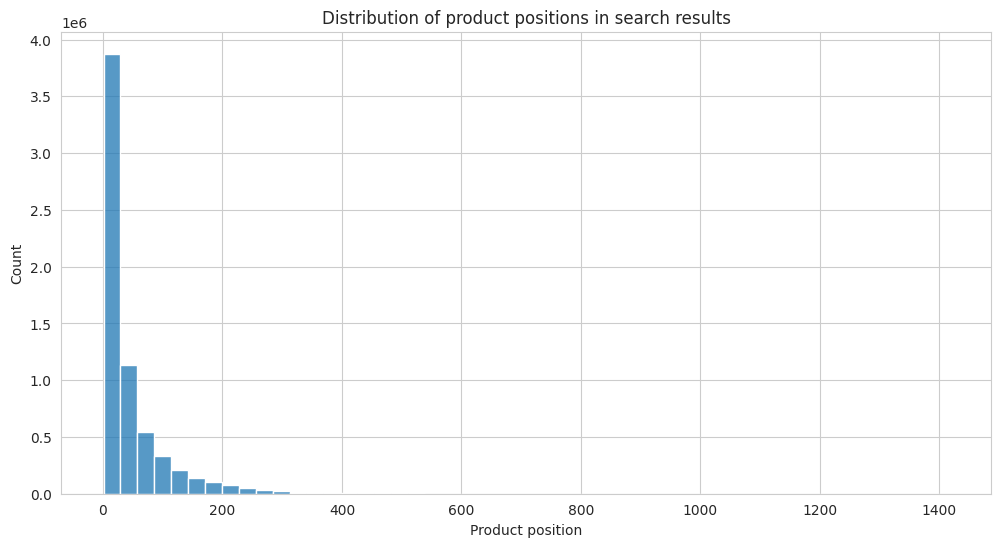

In [23]:
sns.histplot(df_sessions_train['product_position'], bins=50)
plt.title('Distribution of product positions in search results')
plt.xlabel('Product position')
plt.show()

#### Users mostly interact with the products that are shown first (nothing unusual either)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


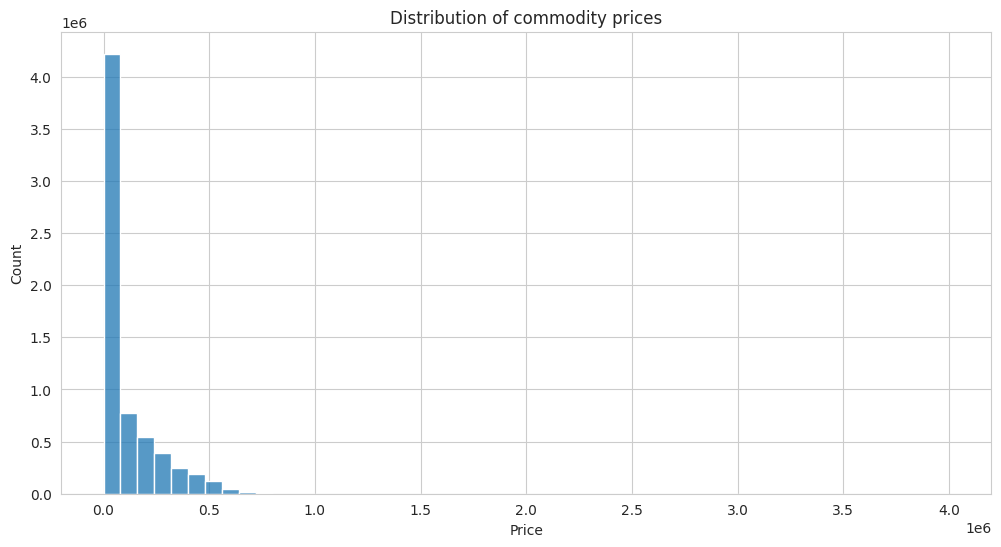

In [24]:
sns.histplot(df_sessions_train['price'], bins=50)
plt.title('Distribution of commodity prices')
plt.xlabel('Price')
plt.show()

#### Price outliers (described earlier, filling error)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


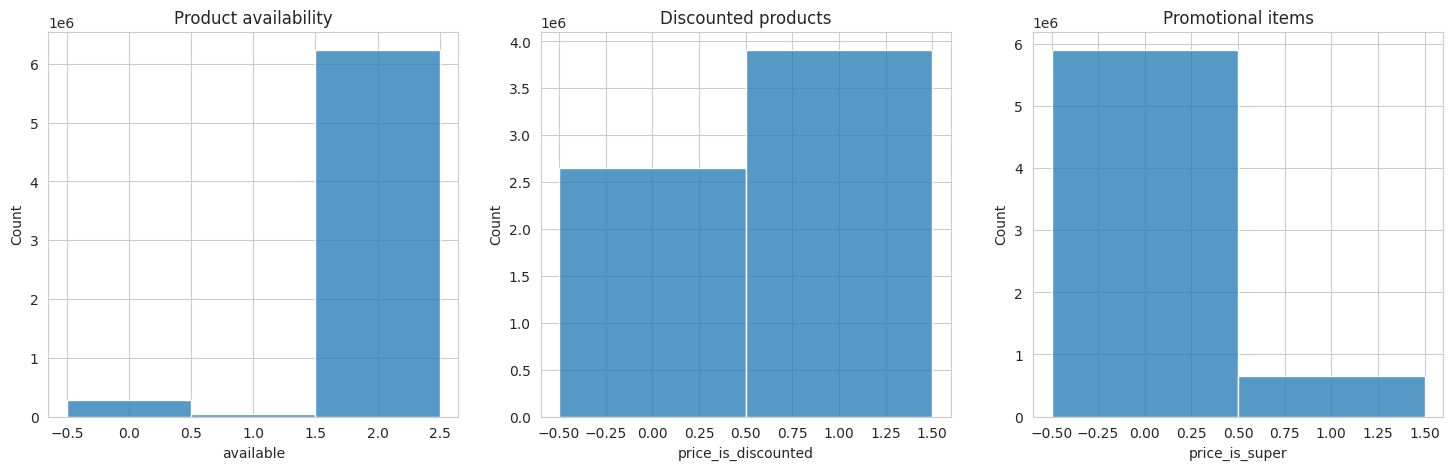

In [25]:
fig, axes = plt.subplots(1,3, figsize=(18,5))

sns.histplot(df_sessions_train['available'], bins=3, discrete=True, ax=axes[0])
axes[0].set_title('Product availability')

sns.histplot(df_sessions_train['price_is_discounted'], bins=2, discrete=True, ax=axes[1])
axes[1].set_title('Discounted products')

sns.histplot(df_sessions_train['price_is_super'], bins=2, discrete=True, ax=axes[2])
axes[2].set_title('Promotional items')

plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


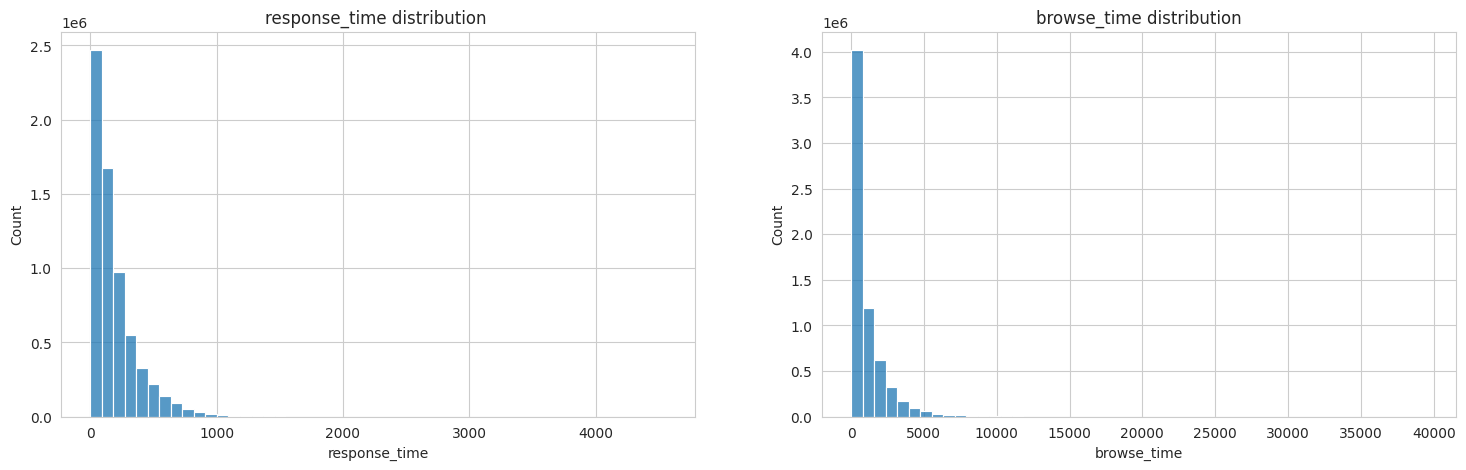

In [26]:
fig, axes = plt.subplots(1,2, figsize=(18,5))

sns.histplot(df_sessions_train['response_time'], bins=50, ax=axes[0])
axes[0].set_title('response_time distribution ')

sns.histplot(df_sessions_train['browse_time'], bins=50, ax=axes[1])
axes[1].set_title('browse_time distribution')

plt.show()

# **3) Feature engineering**

#### The category_name_4 column is the most detailed and refined relative to other category columns, so we use it in conjunction with the type column to create new properties.

In [27]:
df_sessions_train['date'] = pd.to_datetime(df_sessions_train['date'])

In [28]:
def clean_text(text, is_cat_id, morph, stopwords_ru):
    if is_cat_id == 1:  # For the category_name_i columns, it's worth removing the slash, since each of the words it combines can be used to create new properties.
        text = text.replace("/", " ")
    text = text.strip().lower() # Removing spaces and line breaks and convert to lowercase
    text = [
        morph.normal_forms(word.strip())[0] # Lemmatization (reduction to normal form)
        for word in text.split() if word and word not in stopwords_ru # Cutting off stop words
    ]
    return text

In [29]:
# For symbolic features
cat_ids = ['category_name_1', 'category_name_2', 'category_name_3', 'category_name_4']
features = ['type', 'model', 'brand', 'country', 'category_name_1', 'category_name_2', 'category_name_3', 'category_name_4']
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
df_products_cleaned = df_products.copy()
for f in features:
    if f in cat_ids:
        is_cat_id = 1
    else:
        is_cat_id = 0
    df_products_cleaned[f] = df_products[f].apply(lambda x: clean_text(x,is_cat_id, morph, stopwords_ru))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def jaccard_difference(row, morph, stopwords_ru):
    brand_words = set(clean_text(str(row['brand']), 0, morph, stopwords_ru))         # Cleaning the brand
    cat_words = set(clean_text(str(row['category_name_4']), 1, morph, stopwords_ru)) # We are cleaning the 4th level category
    if not brand_words or not cat_words:
        return 1  # Maximum different if one of the fields is empty
    similarity = len(brand_words & cat_words) / len(brand_words | cat_words)  # We calculate the similarity of lists using the Jaccard coefficient
    return 1 - similarity  # "difference" = 1 - similarity

# a) Feature engineering for products

In [31]:
# Let's add some new features by processing the existing ones
df_products['weekday_create'] = df_products['date_of_create'].dt.weekday
df_products['model_len'] = df_products['model'].apply(len) # Model name length
df_products['model_words_count'] = df_products_cleaned['model'].apply(len) # Number of words in the model
df_products_cleaned['brand_category4_diff'] = df_products_cleaned.apply(jaccard_difference, axis=1, args=(morph, stopwords_ru)) # The names in the brand and 4 categories are as similar as possible, so the differences in the names can be useful
df_products['model_slash_count'] = df_products['model'].str.count('/') # Number of slashes in the model name
df_products['model_has_delimeters'] = df_products['model'].apply(lambda x: any(ch in x for ch in ['/', '-', '_', ',','(',')']))  # The presence of a separator in the model name
df_products['numbers_count'] = df_products['model'].str.findall(r'\d+').str.len()  # Number of numbers in the model name
df_products['model_first_word_latin'] = df_products['model'].astype(str).str.match(r'^[A-Za-z]') # If the first word in the model name is in Latin
df_products['product_is_replaced'] = (df_products['replaced_by']!=0).astype(int) # An indication that the product has been replaced by a more relevant product

df_products['date_of_create'] = pd.to_datetime(df_products['date_of_create'])
# Calculation of the difference between the creation date of the replacement product and the current one
df_products = df_products.merge(
    df_products[['product_id', 'date_of_create']],
    left_on='replaced_by',
    right_on='product_id',
    how='left',
    suffixes=('', '_replaced')
)
df_products['days_to_replacement'] = (df_products['date_of_create_replaced'] - df_products['date_of_create']).dt.days.fillna(-1)
# Average lifespan of a brand
brand_avg_lifetime = df_products.groupby('brand')['days_to_replacement'].mean().rename('brand_avg_lifetime') # Average replacement time for each brand
df_products = df_products.merge(brand_avg_lifetime, on='brand', how='left') # Merge the new column with the original dataframe
# A safety net in case you encounter a brand that is not in the initial sample 
# (but is present, for example, in the test sample or after manually adding/correcting the data)
df_products['brand_avg_lifetime'] = df_products['brand_avg_lifetime'].fillna(-1) 
# Average life expectancy for category 1
category1_avg_lifetime = df_products.groupby('category_name_1')['days_to_replacement'].mean().rename('category1_avg_lifetime')
df_products = df_products.merge(category1_avg_lifetime, on='category_name_1', how='left')
df_products['category1_avg_lifetime'] = df_products['category1_avg_lifetime'].fillna(-1)
# Average life expectancy for category 2
category2_avg_lifetime = df_products.groupby('category_name_2')['days_to_replacement'].mean().rename('category2_avg_lifetime')
df_products = df_products.merge(category2_avg_lifetime, on='category_name_2', how='left')
df_products['category2_avg_lifetime'] = df_products['category2_avg_lifetime'].fillna(-1)
# Average life expectancy for category 3
category3_avg_lifetime = df_products.groupby('category_name_3')['days_to_replacement'].mean().rename('category3_avg_lifetime')
df_products = df_products.merge(category3_avg_lifetime, on='category_name_3', how='left')
df_products['category3_avg_lifetime'] = df_products['category3_avg_lifetime'].fillna(-1)
# Average life expectancy for category 4
category4_avg_lifetime = df_products.groupby('category_name_4')['days_to_replacement'].mean().rename('category4_avg_lifetime')
df_products = df_products.merge(category4_avg_lifetime, on='category_name_4', how='left')
df_products['category4_avg_lifetime'] = df_products['category4_avg_lifetime'].fillna(-1)
# Number of replacements by brand
brand_replaced_counts = df_products.groupby('brand')['product_is_replaced'].sum().rename('brand_replaced_count') 
df_products = df_products.merge(brand_replaced_counts, on='brand', how='left')
df_products['brand_replaced_count'] = df_products['brand_replaced_count'].fillna(-1)
# Number of substitutions for category 1
category1_replaced_counts = df_products.groupby('category_name_1')['product_is_replaced'].sum().rename('category1_replaced_count')
df_products = df_products.merge(category1_replaced_counts, on='category_name_1', how='left')
df_products['category1_replaced_count'] = df_products['category1_replaced_count'].fillna(-1)
# Number of substitutions for category 2
category2_replaced_counts = df_products.groupby('category_name_2')['product_is_replaced'].sum().rename('category2_replaced_count')
df_products = df_products.merge(category2_replaced_counts, on='category_name_2', how='left')
df_products['category2_replaced_count'] = df_products['category2_replaced_count'].fillna(-1)
# Number of substitutions for category 3
category3_replaced_counts = df_products.groupby('category_name_3')['product_is_replaced'].sum().rename('category3_replaced_count')
df_products = df_products.merge(category3_replaced_counts, on='category_name_3', how='left')
df_products['category3_replaced_count'] = df_products['category3_replaced_count'].fillna(-1)
# Number of substitutions for category 4
category4_replaced_counts = df_products.groupby('category_name_4')['product_is_replaced'].sum().rename('category4_replaced_count')
df_products = df_products.merge(category4_replaced_counts, on='category_name_4', how='left')
df_products['category4_replaced_count'] = df_products['category4_replaced_count'].fillna(-1)

# b) Feature engineering for sessions

#### We will analyze the user, search query, and product identifiers to understand what a specific user does, how they behave within a single query, and how a product behaves in the context of user interactions with it over time.

In [32]:
# User Features
user_features = df_sessions_train.groupby('user_number').agg(
     un_user_searches=('search_number', 'nunique'),                 # How many search queries were made
     un_user_views=('product_id', 'count'),                         # How many products were viewed
     un_filters_applied_mean=('filters_applied', 'mean'),           # How often were filters used
     un_browse_time_mean=('browse_time', 'mean'),                   # Average time on page
     un_price_is_discounted_mean=('price_is_discounted', 'mean'),   # Percentage of discounted products viewed
     un_available_mean=('available', 'mean')                        # Average availability
).reset_index()

In [33]:
# Фичи поискового запроса
session_features = df_sessions_train.groupby('search_number').agg(
     sn_response_products_mean=('response_products', 'mean'),       # Average number of products found
     sn_browse_time_mean=('browse_time', 'mean'),                   # Average viewing time
     sn_filters_applied_max=('filters_applied', 'max'),             # A filter was applied at least once
     sn_price_mean=('price', 'mean'),
     sn_price_min=('price', 'min'),
     sn_price_max=('price', 'max'),
     sn_price_max_diff=('price', lambda x: x.max() - x.mean()), 
     sn_price_is_discounted_mean=('price_is_discounted', 'mean'),   # Share of discounted goods
     sn_price_is_super_mean=('price_is_super', 'mean'),             # Share of promotional items
     sn_available_mean=('available', 'mean')                        # Average availability
).reset_index()

In [34]:
# Фичи по товару в контексте поиска
product_features = df_sessions_train.groupby('product_id').agg(
     pr_price_mean=('price', 'mean'),                                   # Price statistics for all sessions
     pr_price_min=('price', 'min'),
     pr_price_max=('price', 'max'),
     pr_price_max_diff=('price', lambda x: x.max() - x.mean()),       
     pr_price_is_discounted_mean=('price_is_discounted', 'mean'),       # The probability that this item is on sale
     pr_price_is_super_mean=('price_is_super', 'mean'),                 # The probability that this product is on sale
     pr_available_mean=('available', 'mean'),                           # Average product availability
     pr_relevance_mean=('relevance', 'mean'),                           # Average Engagement (How much clicks translate into purchases)
     pr_relevance_max=('relevance', 'max'),
     pr_relevance_max_diff=('relevance', lambda x: x.max() - x.mean()),
     pr_search_number_count=('search_number', 'count'),                 # How many times was the product found in the search results
     pr_product_position_mean=('product_position', 'mean'),             # Average product position in search results
     pr_product_position_max=('product_position', 'max'),
     pr_product_position_max_diff=('product_position', lambda x: x.max() - x.mean())
).reset_index()

In [35]:
# Then we combine them with the original lines so as not to lose information
df_sessions_train = (
    df_sessions_train
    .merge(user_features, on='user_number', how='left')
    .merge(session_features, on='search_number', how='left')
    .merge(product_features, on='product_id', how='left')
)

In [36]:
df_sessions_train.head()

,query,date,device,user_number,search_number,product_id,selected_category_id,product_position,response_products,response_time,...,pr_price_is_discounted_mean,pr_price_is_super_mean,pr_available_mean,pr_relevance_mean,pr_relevance_max,pr_relevance_max_diff,pr_search_number_count,pr_product_position_mean,pr_product_position_max,pr_product_position_max_diff
0,bagi,2024-07-03,desktop,119760,1963,6221252,10709,2,9,76,...,0.091362,0.093023,1.963455,0.063123,3,2.936877,602,41.219269,447,405.780731
1,bagi,2024-07-03,desktop,119760,1963,6221258,10718,3,3,75,...,0.029586,0.000000,1.946746,0.041420,2,1.958580,169,42.449704,211,168.550296
2,bagi,2024-07-03,desktop,119760,1963,6221260,10718,1,3,75,...,0.026087,0.008696,1.947826,0.130435,3,2.869565,115,47.000000,219,172.000000
3,bagi,2024-07-03,desktop,119760,1963,6221262,10718,2,3,75,...,0.000000,0.016667,1.966667,0.100000,3,2.900000,60,40.150000,243,202.850000
4,bagi,2024-07-03,desktop,119760,1963,6221264,10709,9,9,76,...,0.021186,0.080508,1.809322,0.088983,3,2.911017,236,27.152542,426,398.847458


#### Now we enrich the test data

In [37]:
df_sessions_test = (
    df_sessions_test
    .merge(user_features, on='user_number', how='left')
    .merge(session_features, on='search_number', how='left')
    .merge(product_features, on='product_id', how='left')
)

In [38]:
df_sessions_test=df_sessions_test.fillna(0)

#### Now let's combine session data with product data.

In [39]:
df_train_merged = df_sessions_train.merge(df_products, on='product_id', how='left')
df_test_merged = df_sessions_test.merge(df_products, on='product_id', how='left')

In [40]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6910392 entries, 0 to 6910391
Data columns (total 81 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   query                         object        
 1   date                          datetime64[ns]
 2   device                        object        
 3   user_number                   int64         
 4   search_number                 int64         
 5   product_id                    int64         
 6   selected_category_id          int64         
 7   product_position              int64         
 8   response_products             int64         
 9   response_time                 int64         
 10  browse_time                   int64         
 11  filters_applied               int64         
 12  price_is_discounted           int64         
 13  price_is_super                int64         
 14  price                         int64         
 15  price_discount                in

# **4) Create model**

#### Let's prepare features for the model

In [41]:
df_test_merged.session_product_id

0            10_8080243
1            10_8826131
2            10_7850512
3            10_5897964
4            10_6915061
              ...      
265465    66547_8162696
265466    66547_7309648
265467    66547_9523114
265468    66547_9756367
265469    66547_8649370
Name: session_product_id, Length: 265470, dtype: object

In [42]:
df_test_merged[df_test_merged.duplicated(subset=['session_product_id'], keep=False)]

,query,date,device,user_number,search_number,product_id,selected_category_id,product_position,response_products,response_time,...,brand_avg_lifetime,category1_avg_lifetime,category2_avg_lifetime,category3_avg_lifetime,category4_avg_lifetime,brand_replaced_count,category1_replaced_count,category2_replaced_count,category3_replaced_count,category4_replaced_count
10,",tkbpyf",2025-08-27,desktop,8663,308049,518001,399,11,100,8,...,-58.242424,-5.696028,-4.798175,-5.257548,-5.257548,8,346,206,88,88
11,",tkbpyf",2025-08-27,desktop,8663,308049,518001,399,11,100,8,...,-58.242424,-5.696028,-4.798175,-5.257548,-5.257548,8,346,206,88,88
19,",tkbpyf",2025-08-27,desktop,8663,308049,8373384,399,19,100,8,...,-45.857143,-5.696028,-4.798175,-5.257548,-5.257548,2,346,206,88,88
20,",tkbpyf",2025-08-27,desktop,8663,308049,8373384,399,19,100,8,...,-45.857143,-5.696028,-4.798175,-5.257548,-5.257548,2,346,206,88,88
26,",телефон кнопочный нокио220",2025-07-04,mobile,34615,95465,8415038,99,3,15,3,...,-41.316484,-7.539579,-8.771837,-8.771837,-8.771837,44,461,341,341,341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265411,эплвотчки,2025-08-14,app,127888,128957,8949857,563,34,42,4,...,-9.169323,-7.539579,-5.337188,-4.743140,-4.743140,64,461,120,112,112
265412,эплвотчки,2025-08-14,app,127888,128957,8746405,563,35,42,4,...,-9.169323,-7.539579,-5.337188,-4.743140,-4.743140,64,461,120,112,112
265413,эплвотчки,2025-08-14,app,127888,128957,8746405,563,35,42,4,...,-9.169323,-7.539579,-5.337188,-4.743140,-4.743140,64,461,120,112,112
265414,эплвотчки,2025-08-14,app,127888,128957,8169779,563,36,42,4,...,-9.169323,-7.539579,-5.337188,-4.743140,-4.743140,64,461,120,112,112


In [43]:
len(df_train_merged), df_train_merged[['search_number', 'product_id']].drop_duplicates().shape[0]


(6910392, 6558319)

In [44]:
df_test_merged = df_test_merged.drop_duplicates(subset=['session_product_id'], keep='first')
df_train_merged = df_train_merged.drop_duplicates(subset=['search_number', 'product_id'])

In [45]:
print(len(df_test_merged))

252720


In [46]:
target = 'relevance'
numeric_cols = [
    'price', 'price_discount', 'browse_time', 'product_position', 'product_age_days',
    'model_len', 'model_words_count', 'model_slash_count', 'numbers_count',
    'days_to_replacement', 'product_id_replaced',
    'un_user_searches', 'un_user_views', 'un_filters_applied_mean', 'un_browse_time_mean', 'un_price_is_discounted_mean', 'un_available_mean',
    'sn_response_products_mean', 'sn_browse_time_mean', 'sn_filters_applied_max', 'sn_price_mean', 'sn_price_min', 'sn_price_max', 'sn_price_max_diff',
    'sn_price_is_discounted_mean', 'sn_price_is_super_mean', 'sn_available_mean',
    'pr_price_mean', 'pr_price_min', 'pr_price_max', 'pr_price_max_diff', 'pr_price_is_discounted_mean',
    'pr_price_is_super_mean', 'pr_available_mean', 'pr_relevance_mean', 'pr_relevance_max', 'pr_relevance_max_diff',
    'pr_search_number_count', 'pr_product_position_mean', 'pr_product_position_max', 'pr_product_position_max_diff'
]
categorical_cols = [
    'device', 'brand', 'type', 'category_name_1', 'category_name_2', 'category_name_3', 'category_name_4',
    'available', 'replaced_by', 'country', 'model_has_delimeters', 'model_first_word_latin'
]

df_train_sorted = df_train_merged.sort_values('search_number')
X_train_sorted  = df_train_sorted[numeric_cols + categorical_cols].fillna(0)
y_train_sorted  = df_train_sorted[target]
group_id_train_sorted  = df_train_sorted['search_number'].values
    
df_test_sorted  = df_test_merged.sort_values('search_number')
X_test  = df_test_sorted[numeric_cols + categorical_cols].fillna(0)

cat_features_idx = [X_train_sorted.columns.get_loc(c) for c in categorical_cols] # We'll use CatBoost as the training model. To process categorical features, it needs to know their indices.

In [47]:
ranker = CatBoostRanker(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='NDCG',
    random_seed=42,
    verbose=100
)

ranker.fit(
    X_train_sorted,
    y_train_sorted,
    group_id=group_id_train_sorted,
    cat_features=cat_features_idx
)

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 17.1s	remaining: 2h 21m 56s
100:	total: 25m 45s	remaining: 1h 41m 45s
200:	total: 51m 55s	remaining: 1h 17m 14s
300:	total: 1h 17m 41s	remaining: 51m 21s
400:	total: 1h 44m 26s	remaining: 25m 47s
499:	total: 2h 10m 14s	remaining: 0us


In [48]:
submission['session_product_id'] = df_test_merged['search_number'].astype(str) + "_" + df_test_merged['product_id'].astype(str)

# relevance — model predictions
submission['relevance'] = ranker.predict(X_test)

# Save predictions
submission.to_csv("submission.csv", index=False)

In [49]:
submission

,session_product_id,relevance
0,308049_8080243,5.257672
1,308049_8826131,4.940732
2,308049_7850512,4.566130
3,308049_5897964,4.558471
4,308049_6915061,4.430371
...,...,...
252715,418046_8493712,4.725032
252716,418046_8497799,3.425970
252717,418046_9747899,4.696855
252718,418046_7914722,4.561784
